# Classifier

Explanation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Select Dataset

In [3]:
# load data
dataset_con = pd.read_csv('data/dataset_con.csv')
dataset_bin = pd.read_csv('data/dataset_bin.csv')
# To use dataset_con rather than dataset_bin, comment out the following line
df = dataset_bin
# To use dataset_con rather than dataset_bin, uncomment the following line
#df = dataset_con


### Feature Correlation

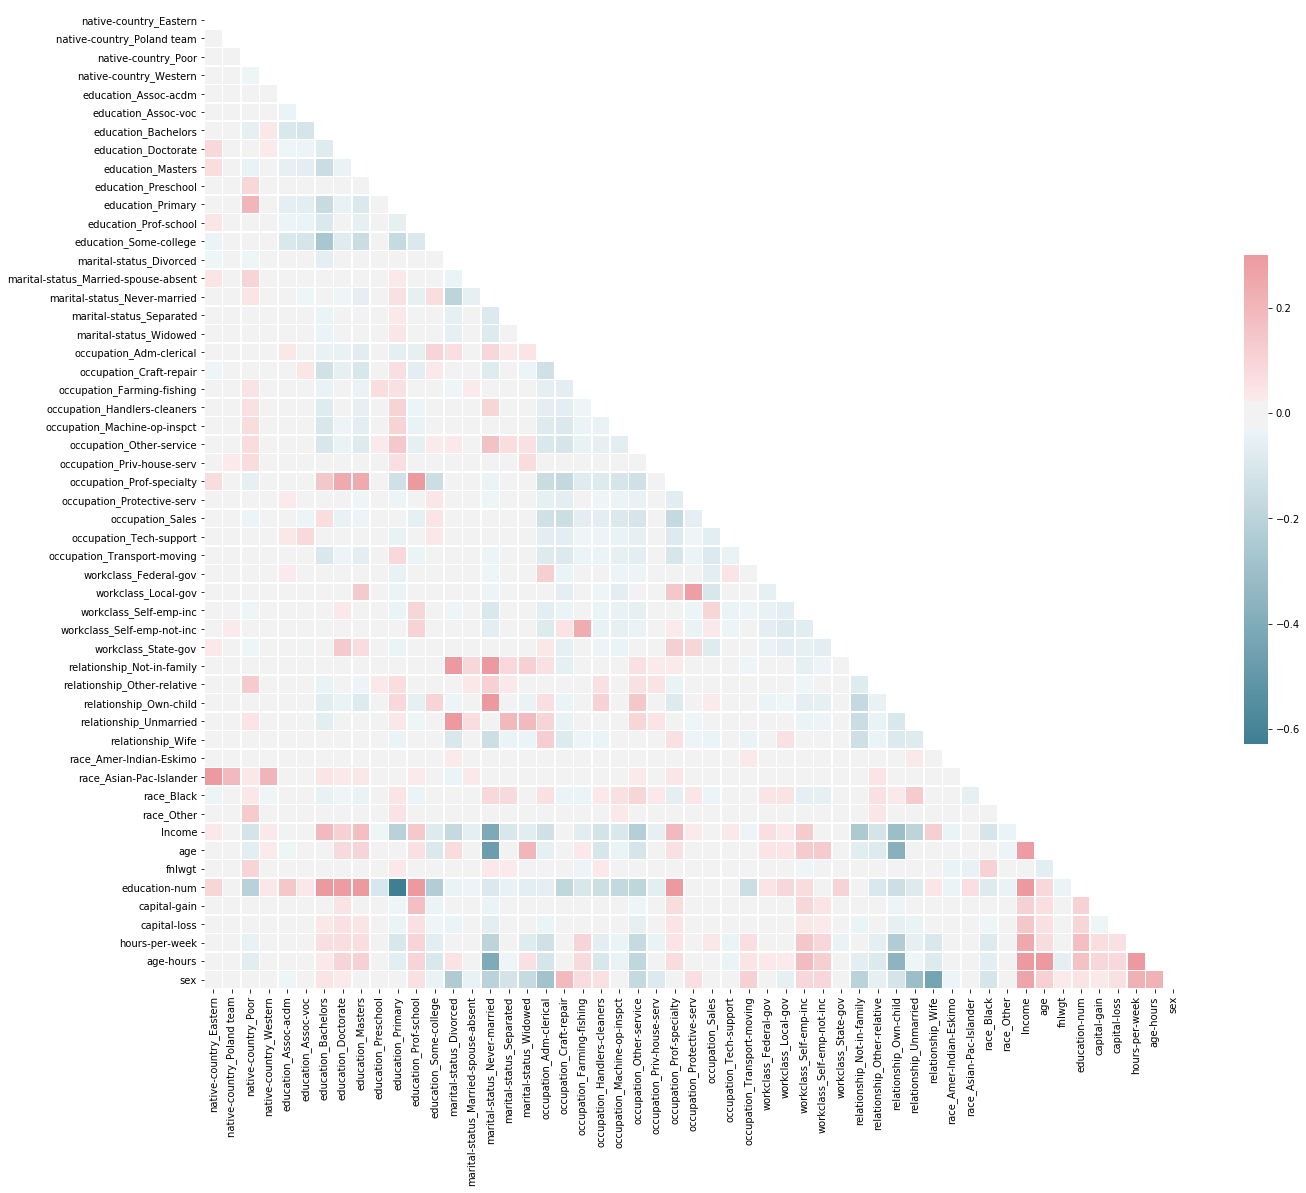

In [4]:
# Compute the correlation matrix
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The above heatmap is the correlation matrix of all features and the target ('Income'). It reveals that the dataset isn't overly correlated because there are few dark patches. There are, however, some instances of high correlation. For example, 'relationship' and 'sex' are negatively correlated, which makes sense because male and husband co-occur frequently.

### Feature Importance

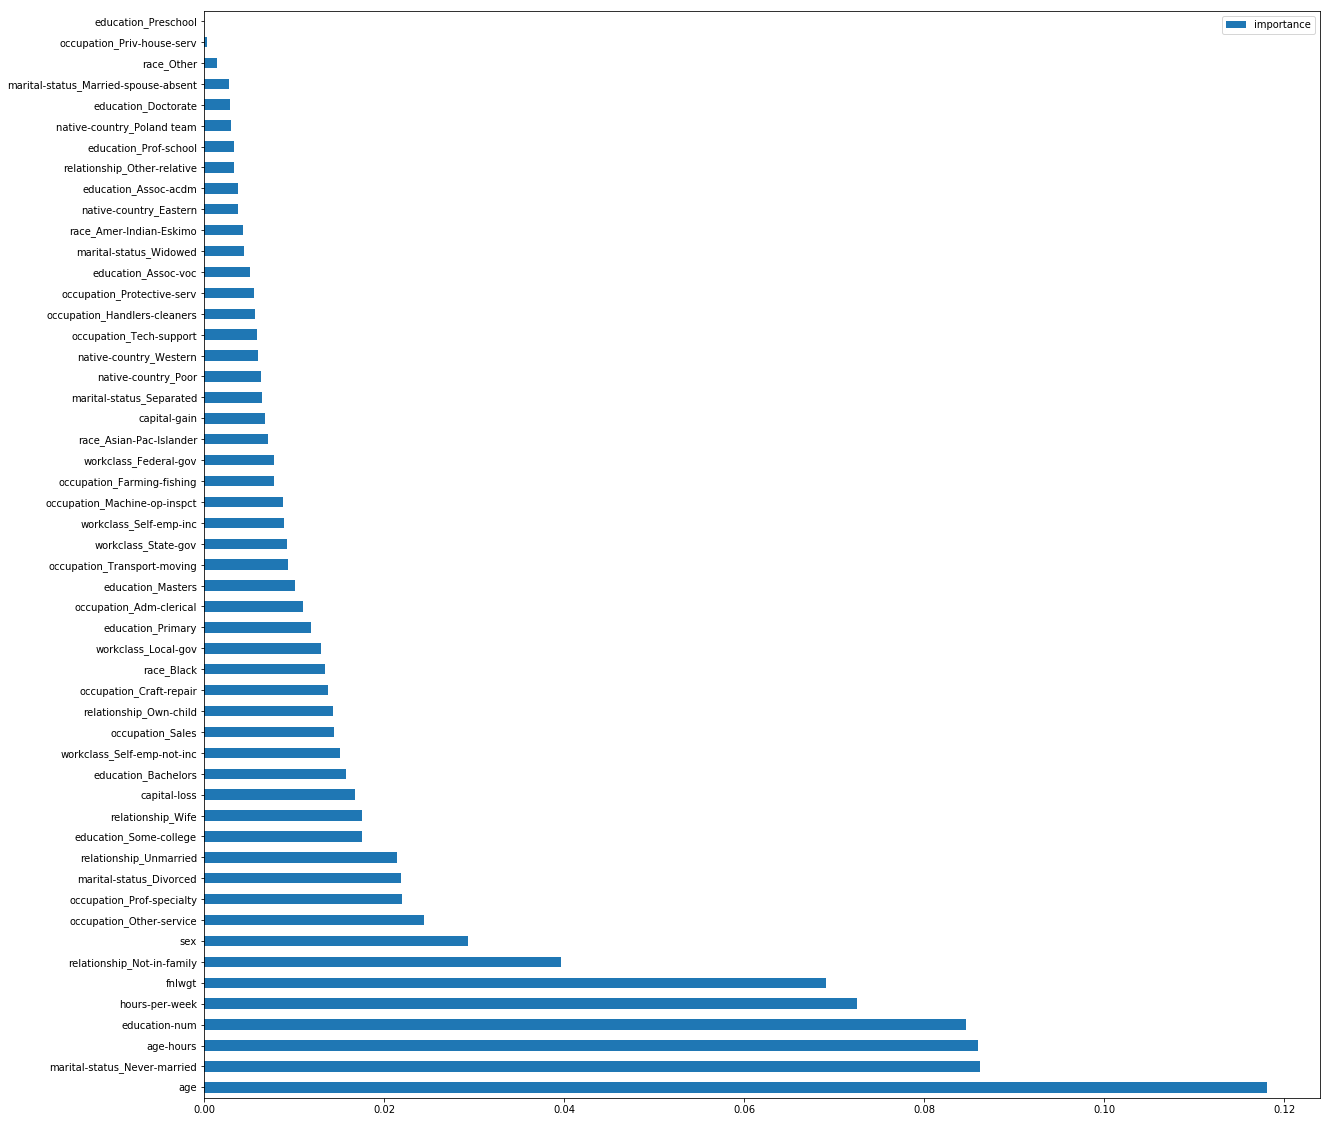

In [5]:
split_index = int(round(df.shape[0]*0.8))

train_set = df.iloc[0:split_index]
test_set = df.iloc[split_index:,]

X_train = train_set.drop('Income', axis=1)
y_train = train_set['Income']
#print X_train.info()
#print y_train.info()

X_test = test_set.drop('Income', axis=1)
y_test = test_set['Income']

rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_test, y_test)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
#print feature_importances

feature_importances.plot.barh(figsize=(20,20))


### Recursive Feature Elimination

Optimal number of features : 52


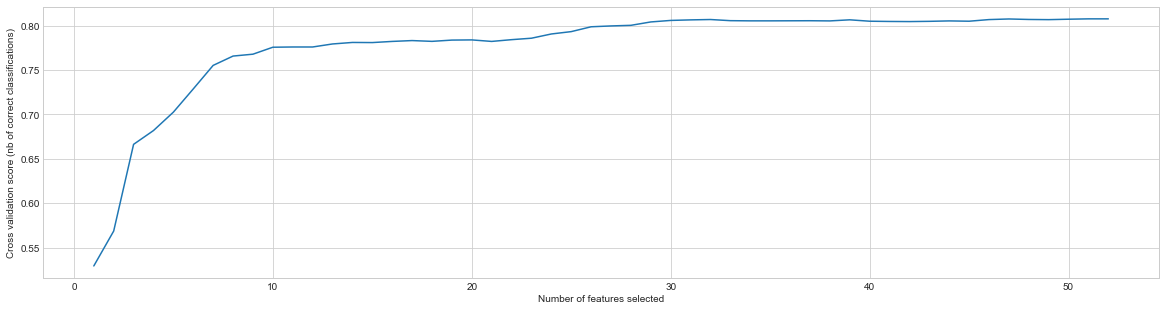

In [6]:
a = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
a = a.fit(df.drop('Income', axis=1).values, df['Income'].values)

print("Optimal number of features : %d" % a.n_features_)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(a.grid_scores_) + 1), a.grid_scores_);

df = df[df.columns[np.insert(a.support_, 0, True)]]

# Models

### Feature Normalization / Standardization

In [7]:
min_max_scaler = MinMaxScaler()

train_data_knn = min_max_scaler.fit_transform(X_train)
train_labels_knn = y_train
test_data_knn = min_max_scaler.transform(X_test)
test_labels_knn = y_test

std_scaler = StandardScaler()

train_data_std = std_scaler.fit_transform(X_train)
train_labels_std = y_train
test_data_std = std_scaler.transform(X_test)
test_labels_std = y_test

### Baseline Metrics

In [8]:
# Baseline
baseline_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train,y_train)
print '-------------------Baseline-------------------'
print 'Accuracy When Guessing Most Frequent: {:.2f}'.format(baseline_clf.score(X_test, y_test))

# Bayes Error Rate
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print '\n---------------Bayes Error Rate---------------'
print 'KNN accuracy with k=1: %s' % metrics.accuracy_score(y_test, y_pred)

-------------------Baseline-------------------
Accuracy When Guessing Most Frequent: 0.51

---------------Bayes Error Rate---------------
KNN accuracy with k=1: 0.7330609465440926


### KNN

In [9]:
model = KNeighborsClassifier()

params = {"n_neighbors": np.arange(1, 31, 1),"metric": ["euclidean", "cityblock"]}

grid = RandomizedSearchCV(model, params)
grid.fit(train_data_knn, train_labels_knn)

acc = grid.score(test_data_knn, test_labels_knn)
print("[INFO] randomized search best parameters: {}".format(grid.best_params_))
print 'Accuracy: %f \n' % acc
print(classification_report(y_test, grid.predict(test_data_knn)))

[INFO] randomized search best parameters: {'n_neighbors': 28, 'metric': 'euclidean'}
Accuracy: 0.798093 

             precision    recall  f1-score   support

          0       0.84      0.73      0.78      1443
          1       0.77      0.86      0.81      1494

avg / total       0.80      0.80      0.80      2937



### Random Forest Classifier

The three cells below enable either direct tuning of the hyperparameters (first via a random search then a narrower grid search) or simply running the classifier using preset values for hyperparameters that I attained through tuning in this manner. Please note that the first two cells (direct tuning of hyperparameters) are compute-intensive and took ~90 minutes to run on my system. 

#### Direct Tuning

To find a good region of the hyperparameter space to search more exhaustively, first perform a random search over the hyperparameter space.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print("[INFO] random search best parameters: {}".format(rf_random.best_params_))


Based on the values returned from the random search, create a new parameter grid with narrower bounds to search more exhaustively in order to determine hyperparameters to be used for evaluating this model.

In [ ]:
# Choose hyperparameter options for grid search based off best paramaters returned from random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [16, 18, 20, 22],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [500, 800, 1000, 1200]
}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("[INFO] grid search best parameters: {}".format(grid_search.best_params_))
acc = best_model.score(X_test, y_test)
print 'Accuracy: %f \n' % acc
print(classification_report(y_test, best_model.predict(X_test)))

#### Evaluate the Random Forest Classifier using predefined hyperparameters

In [10]:
model = RandomForestClassifier(bootstrap=False, min_samples_leaf=5, n_estimators=800, min_samples_split=5, max_features='auto', max_depth=16)
model.fit(X_train, y_train)

print '[INFO] bootstrap: False, min_samples_leaf: 5, n_estimators: 800, min_samples_split: 5, max_features: auto, max_depth: 16'
acc = metrics.accuracy_score(y_test, model.predict(X_test))
print 'Accuracy %f \n' % acc
print classification_report(y_test, model.predict(X_test))

[INFO] bootstrap: False, min_samples_leaf: 5, n_estimators: 800, min_samples_split: 5, max_features: auto, max_depth: 16
Accuracy 0.808648 

             precision    recall  f1-score   support

          0       0.84      0.76      0.80      1443
          1       0.79      0.86      0.82      1494

avg / total       0.81      0.81      0.81      2937



### Logistic Regression

In [11]:
logistic = LogisticRegression()
hyperparameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'] }

clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(train_data_std, train_labels_std)

print("[INFO] grid search best parameters: {}".format(clf.best_params_))
acc = best_model.score(test_data_std, test_labels_std)
print 'Accuracy: %f \n' % acc
print(classification_report(y_test, best_model.predict(test_data_std)))

[INFO] grid search best parameters: {'penalty': 'l2', 'C': 0.01}
Accuracy: 0.805924 

             precision    recall  f1-score   support

          0       0.82      0.77      0.80      1443
          1       0.79      0.84      0.82      1494

avg / total       0.81      0.81      0.81      2937

